In [34]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
import cv2 as cv
import os
from matplotlib import pyplot as plt
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16

In [35]:
train_dir = 'FIXING/train'
validation_dir = 'FIXING/validation'
test_dir = 'FIXING/test'

In [36]:
# Define parameters
batch_size = 16
target_size = (224, 224)

# Data augmentation and brightness enhancement for training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=[0.9, 1.1]
)

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Only rescale for validation and test datasets
validation_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=1,  
    class_mode='categorical',
    shuffle=False
)

Found 9381 images belonging to 14 classes.
Found 1172 images belonging to 14 classes.
Found 1176 images belonging to 14 classes.


In [37]:
train_dataset.class_indices

{'Bakso': 0,
 'Burger': 1,
 'Caesar Salad': 2,
 'Cumi Goreng Tepung': 3,
 'Kerang Tiram': 4,
 'Nasi': 5,
 'Nasi Goreng': 6,
 'Omelette': 7,
 'Sate Ayam': 8,
 'Sayap Ayam Goreng': 9,
 'Siomay': 10,
 'Spaghetti': 11,
 'Steak': 12,
 'Yoghurt': 13}

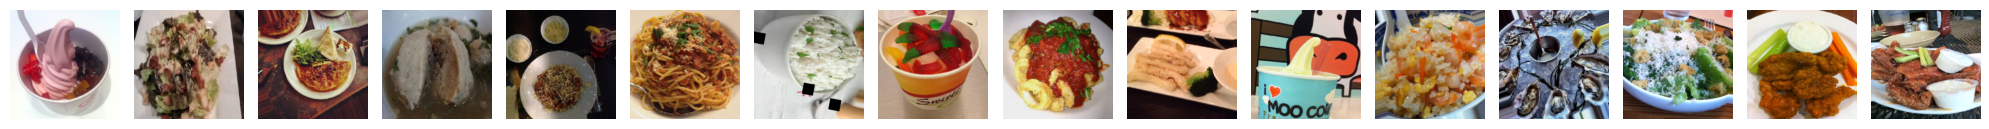

In [38]:
# Plot augmented images
def plot_augmented_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Retrieve a batch of images from the training dataset
images, labels = next(train_dataset)

# Plot the augmented images
plot_augmented_images(images)

In [39]:
# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [40]:
# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.6),
    layers.Dense(train_dataset.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model
evaluation = model.evaluate(test_dataset)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

model.save('ImageClassification.h5')

Epoch 1/30
587/587 [==============================] - 108s 182ms/step - loss: 2.4358 - accuracy: 0.4169 - val_loss: 1.7538 - val_accuracy: 0.6340 - lr: 1.0000e-04
Epoch 2/30
587/587 [==============================] - 109s 185ms/step - loss: 1.7845 - accuracy: 0.5748 - val_loss: 1.4941 - val_accuracy: 0.6749 - lr: 1.0000e-04
Epoch 3/30
587/587 [==============================] - 99s 168ms/step - loss: 1.5197 - accuracy: 0.6343 - val_loss: 1.3469 - val_accuracy: 0.6783 - lr: 1.0000e-04
Epoch 4/30
587/587 [==============================] - 95s 161ms/step - loss: 1.3480 - accuracy: 0.6675 - val_loss: 1.2119 - val_accuracy: 0.7159 - lr: 1.0000e-04
Epoch 5/30
587/587 [==============================] - 102s 174ms/step - loss: 1.2587 - accuracy: 0.6923 - val_loss: 1.1942 - val_accuracy: 0.7099 - lr: 1.0000e-04
Epoch 6/30
587/587 [==============================] - 94s 161ms/step - loss: 1.1438 - accuracy: 0.7223 - val_loss: 1.1526 - val_accuracy: 0.7304 - lr: 1.0000e-04
Epoch 7/30
587/587 [=====

In [41]:
from sklearn.metrics import classification_report
import numpy as np

predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

1176/1176 [==============================] - 14s 11ms/step
                    precision    recall  f1-score   support

             Bakso       0.89      0.53      0.67        15
            Burger       0.70      0.72      0.71       100
      Caesar Salad       0.66      0.84      0.74       100
Cumi Goreng Tepung       0.84      0.66      0.74       100
      Kerang Tiram       0.89      0.85      0.87       100
              Nasi       0.98      0.98      0.98        43
       Nasi Goreng       0.85      0.79      0.82       100
          Omelette       0.66      0.67      0.66       100
         Sate Ayam       1.00      0.56      0.71        18
 Sayap Ayam Goreng       0.62      0.61      0.62       100
            Siomay       0.88      0.76      0.82       100
         Spaghetti       0.81      0.86      0.83       100
             Steak       0.57      0.66      0.61       100
           Yoghurt       0.84      0.91      0.87       100

          accuracy                     

In [15]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to a file
with open('ImageClassification.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite format and saved as 'ImageClassification.tflite'")


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpl16sq4tc\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpl16sq4tc\assets


Model converted to TensorFlow Lite format and saved as 'ImageClassification.tflite'


1/1 [==============================] - 0s 25ms/step
Prediction : Bakso
1.0


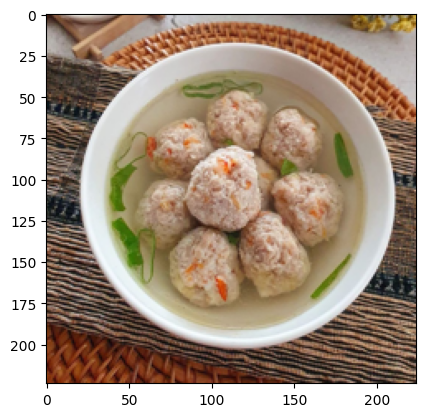

In [45]:
import requests
from io import BytesIO
from PIL import Image

url = "https://cdn.idntimes.com/content-images/community/2023/07/1690271894048-050d7c823376e5868043b1f6ae8078e6-a75e426088cef429cd54472c97c5b031.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB')

img_height, img_width = (224, 224)
image = image.resize((img_height, img_width))
image_array = np.array(image)
image_array = np.expand_dims(image_array, axis=0)

plt.imshow(image_array.reshape(img_height, img_width, 3))

predictions = model.predict(image_array)
class_labels = [i for i in train_dataset.class_indices]

print(f'Prediction : {class_labels[np.argmax(predictions)]}')
print(predictions[0][np.argmax(predictions)])